# Moving average trading

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive, interactive_output
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText
from ipywidgets import jslink
from IPython.display import display

import trading as tra
import trading_plots as trp
from trading_defaults import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Default parameters

In [2]:
TICKER     = 'ETH-USD'
REFRESH    = True # Download fresh Yahoo data 

START_DATE = '2017-07-15'
END_DATE   = '2021-03-24' # make today

### Data download

In [3]:
raw = tra.load_security(dirname = DATA_DIR, 
                        ticker  = TICKER, 
                        refresh = REFRESH, 
                        period  = DEFAULT_PERIOD,
                        )
security = pd.DataFrame(raw[f'Close_{TICKER}'])
security.rename(columns={f'Close_{TICKER}': "Close"},
                inplace=True)

security

Loading ticker ETH-USD
[*********************100%***********************]  1 of 1 completed


,Close
Date,
2016-03-26,10.9740000
2016-03-27,10.4191999
2016-03-28,11.6655998
2016-03-29,11.6563997
2016-03-30,11.9528999
...,...
2021-03-22,1691.3339844
2021-03-23,1678.6501465
2021-03-24,1593.4134521


#### Setup default start & end dates

In [4]:
# Check dates 
#print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_dates(security, START_DATE, END_DATE))
#print(tra.get_filename_dates(security, START_DATE, END_DATE))

(datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 24, 0, 0))


## Plotting functions

### Main plotting function

In [5]:
def plot_moving(span, fee_pct, buffer, date_range):
    '''
    Plots security prices with moving average 
    span -> rolling window span
    fee_pct -> fee associated with a buy/sell action 
    '''
    #reactivity = REACTIVITY
    start = date_range[0]
    end   = date_range[1]
    title_dates = tra.dates_to_strings([start, end], '%d-%b-%Y')
    file_dates  = tra.dates_to_strings([start, end], '%Y-%m-%d')

    # Extract time window
    df = tra.build_strategy(TICKER,
                            security.loc[start:end, :].copy(),
                            span,
                            buffer,
                            INIT_WEALTH,
                           )
    fee  = tra.get_fee(df, fee_pct, ACTIONS)
    hold = tra.get_cumret(df, 'hold')  # cumulative returns for hold strategy
    ema  = tra.get_cumret(df, 'ema', fee)  # cumulative returns for EMA strategy

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(df.index, df.Close, linewidth=1, label='Price')
    ax.plot(df.index, df.EMA, linewidth=1, label=f'{span}-days EMA')

    ax.legend(loc='best')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(get_year_month_format())
    ax.grid(b=None, which='both', axis='both',
             color=GRID_COLOR, linestyle='-', linewidth=1)
    
    n_buys, n_sells= trp.plot_arrows(ax, df, ACTIONS, get_color_scheme())

    title  = f'{TICKER} | '
    title += f'{title_dates[0]} - {title_dates[1]} | '
    title += f'{n_buys} buys {n_sells} sells\n'
    title += f'EMA payoff={ema:.2%} (Hold={hold:.1%}) | '
    title += f'{span}-day rolling mean | {buffer:.2%} buffer'
    ax.set_title(title, fontsize=TITLE_SIZE, color=TITLE_COLOR)

    trp.save_figure(PLOT_DIR, f'{TICKER}_{file_dates[0]}_{file_dates[1]}')
    return df

In [6]:
def plot_span_range(buffer, n_values, fee_pct, date_range):
    trp.plot_span_range(buffer     = buffer, 
                        n_values   = n_values, 
                        fee_pct    = fee_pct, 
                        date_range = date_range, 
                        ticker     = TICKER, 
                        security   = security, 
                       )

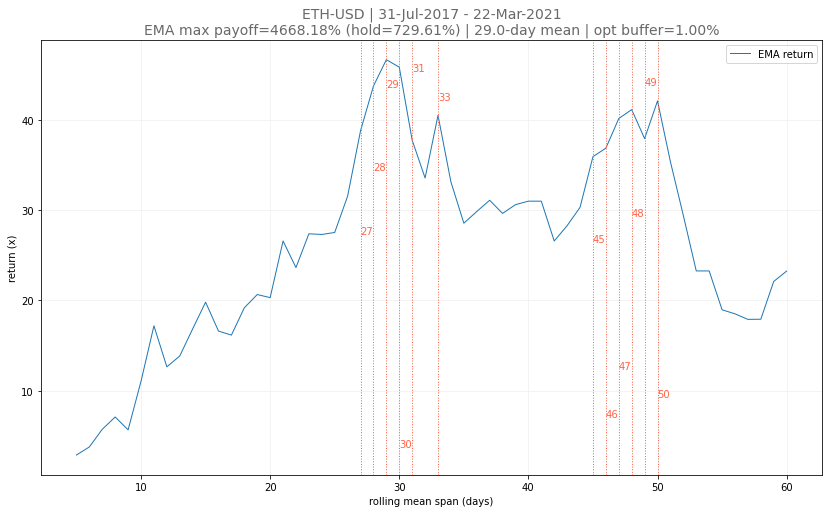

In [7]:
#### test driver for trp.plot_span_range
plot_span_range(buffer     = .01, 
                n_values   = 12, 
                fee_pct    = FEE_PCT, 
                date_range = [datetime.strptime('2017-07-31', '%Y-%m-%d'), 
                              datetime.strptime('2021-03-22', '%Y-%m-%d')], 
               )

In [8]:
def plot_buffer_range(span, n_values, fee_pct, date_range):
    trp.plot_buffer_range(span     = span, 
                          n_values   = n_values, 
                          fee_pct    = fee_pct, 
                          date_range = date_range, 
                          ticker     = TICKER, 
                          security   = security, 
                         )
    #start_string, end_string = tra.dates_to_strings(date_range)

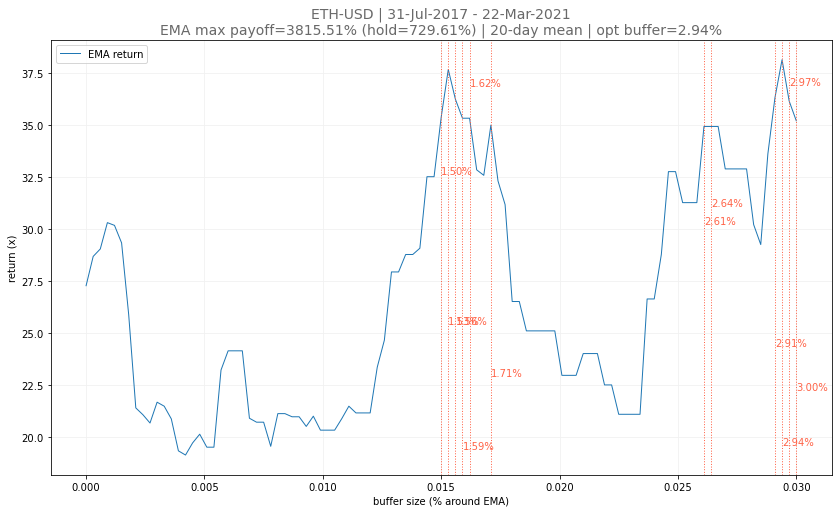

In [9]:
#### test driver for trp.plot_span_range
plot_buffer_range(span     = 20, 
                n_values   = 12, 
                fee_pct    = FEE_PCT, 
                date_range = [datetime.strptime('2017-07-31', '%Y-%m-%d'), 
                              datetime.strptime('2021-03-22', '%Y-%m-%d')], 
               )

In [ ]:
# Contour plot of EMA for all window span/buffer size combinations
def plot_buffer_span_contours():
    '''
    Contour plot of EMA as a function of rolling-window span & buffer
    '''
    fig_size   = (FIG_WIDTH, FIG_WIDTH) # square figure
    n_contours = 10 # number of contours
    n_maxima_p = 10 # number of maximum points to plot
    n_maxima_s = 25 # number of maximum points to save to file

    # Get start & end dates in various fomats
    start, end             = tra.get_datetime_dates(security, START_DATE, END_DATE)
    start_title, end_title = tra.dates_to_strings([start, end], '%d-%b-%Y')
    start_name, end_name   = tra.dates_to_strings([start, end], '%Y-%m-%d')
    #tra.get_title_dates(security, START_DATE, END_DATE)
    #start_name, end_name   = tra.get_filename_dates(security, START_DATE, END_DATE)
    
    spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, start, end)
    
    # Plot
    fig, ax = plt.subplots(figsize=fig_size)
    plt.contourf(buffers, spans, emas, 
                 levels=n_contours, 
                 cmap='viridis', 
                 )
    plt.colorbar(label='EMA return')
            
    # Plot maxima points 
    max_ema, max_span, max_buff = trp.plot_maxima(emas, 
                                                  spans, 
                                                  buffers, 
                                                  hold, 
                                                  ax, 
                                                  n_maxima_p)
    
    tra.results_to_file(TICKER, spans, buffers, emas, hold, n_maxima_s)
        
    # Axis labels
    ax.set_xlabel('buffer')
    ax.set_ylabel('span')
    
    # Build title
    title  = f'{TICKER} | {start_title} - {end_title}\n'
    title += f'EMA max payoff={max_ema:.2%} (hold={hold:.2%}) | '
    title += f'{max_span:.0f}-day mean | '
    title += f'opt buffer={max_buff:.2%}'
    ax.set_title(title, fontsize=TITLE_SIZE, color=TITLE_COLOR)
    
    plt.grid(b=None, which='major', axis='both', color=GRID_COLOR)
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_name}_{end_name}_contours', extension='jpg')
    plt.show()
    
plot_buffer_span_contours()
    

### Interactive plots

#### Widget defaults

In [10]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_dates(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = FEE_PCT

# of days for running mean
min_span     = MIN_SPAN
max_span     = MAX_SPAN
delta_span   = 1
default_span = 20

# buffer around EMA
min_buffer     = MIN_BUFF
max_buffer     = MAX_BUFF
delta_buffer   = .0001
default_buffer = .01

# number of maxima
max_value     = 15
default_value = 12


In [11]:
## Widget methods

### Sliders
def get_span_slider():
    return IntSlider(min = min_span,
                     max=max_span,
                     step=delta_span,
                     value=default_span,
                     #description='Mean span:',
                     style=string_style,
                     disabled=False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        #description='Buffer (%):',
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       #description='Fees (%):',
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
   return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )
### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return FloatText(min=min_span,
                     max=max_span,
                     step=delta_span,
                     value=default_span,
                     description='Span:',
                     style=string_style,
                     disabled=False,
                     readout_format='d',
                     layout={'width': '150px'},
                    )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )


#### Interactive returns for window span

In [16]:
# Mean window span range optimizer interactive
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive returns for buffer size

In [17]:
# Buffer range optimizer interactive 
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive buffer-span

In [15]:
# Buffer-span interactive plot

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

date_range_slider = get_date_range_slider()

out = interactive_output(plot_moving,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])


ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = buffer_widgets,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()